In [2]:
import sdeint
import numpy as np
import csv
#import random as rand
import matplotlib.pyplot as plt
#from itertools import accumulate
from scipy.optimize import curve_fit
from synthetic_env import synthetic_env
from naive_agents import DoNothing, FixedPhi
#from scipy.stats import norm

## First run Numerics Outside of Environment

In [3]:
def expected_prop_2d(r,PHI,D,r_d,scaling=1.0):
    return scaling*np.power((r_d/r),(2*(PHI-D)/D))/r

def f(u, t):
    #print(u)
    return np.array([
        u[2]*u[0] + u[3]*u[1] - PHI * u[0],
        u[4]*u[0] + u[5]*u[1] - PHI * u[1],
        -u[2],
        -u[3],
        -u[4],
        -u[5]
    ])

def g(u, t):
    return np.array([
        [np.sqrt(kappa), 0, 0, 0, 0],
        [0, np.sqrt(kappa), 0, 0, 0],
        [0, 0, np.sqrt(D), 0, 0],
        [0, 0, 0, np.sqrt(D), np.sqrt(2) * np.sqrt(D)],
        [0, 0, 0, np.sqrt(D), -np.sqrt(2) * np.sqrt(D)],
        [0, 0, -np.sqrt(D), 0, 0]
    ])

def penalty(sep,phi,beta,delta_t):
    return (phi**2+beta)*sep**2*delta_t

In [4]:
# Choose Params
dim=2
kappa = 0.001
D = 0.1
BETA = 0.1
D_tilde = D*(dim+1)*(dim-1)
PHI = 0.25#(D_tilde + np.sqrt(4*BETA+D_tilde))/2
r_d = np.sqrt(kappa/D)

delta_t = 0.1
NU = 0.99
#Params that are close to ABC flow params

#PHI = 0.7  
#kappa = 0.02*np.pi
#D = 0.25
#r_d = np.sqrt(kappa/D)
print(PHI)

0.25


In [6]:
(D_tilde + np.sqrt(4*BETA+D_tilde**2))/2

0.5

In [12]:
# Run the SDEs
dictionary = {}
num_eps = 1000
noise_initial = np.array([0,0,0,0,0,0])
noise_initial[:2] = np.random.rand(2) - 0.5
for i in range(num_eps):
    u0 = noise_initial


    tspan = np.arange(0.0, 10.0,delta_t)  # 100 time units

    result = sdeint.itoint(f, g, u0, tspan)
    
    # storing last value for the random start of the next value in the uhlenbreck processes
    noise_initial = result[-1]

    separations = np.sum(result[:, :2]**2, axis=1)
    separations = np.sqrt(separations)


    N = len(separations)
    S_n = 0.0
    returns = np.zeros(N)
    discount = np.exp(-NU*delta_t)
    for i in range(1,N+1):
        S_n = S_n*discount + penalty(separations[N-i],PHI,BETA,delta_t)
        returns[N-i] = S_n
        
    
    delta_r = 0.002
    for i in range(N):
        key = (i, int(separations[i]/delta_r))
        if key in dictionary:
            # increase sum and count
            dictionary[key] = dictionary[key][0] + returns[i], dictionary[key][1] + 1
        else:
            dictionary[key] = [returns[i], 1]
    

In [5]:
with open(f'noise_corrected_bins_{num_eps}_{delta_t}_continuing.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(dictionary.keys()))
    writer.writeheader()
    writer.writerow(dictionary)

In [6]:
# Specfic to 2 dimensions
def baseline(time_remaining,separation):
    dims=2
    # a useful intermediate value used in the baseline calculations
    d_tilde = 4*D
    block = NU + 2*PHI - d_tilde
    
    def A():
        num = (BETA + PHI**2)*(1-np.exp(-time_remaining*block))
        denom = block
        return num/denom
    
    def B():
        first_term = dims * kappa * (BETA + PHI**2) / (NU*(2*PHI-d_tilde))
        second_term = 1 - np.exp(-NU*time_remaining) - NU * (1-np.exp(-time_remaining*block))/block
        return first_term*second_term
        
    
    return A()*separation**2 + B()

In [10]:
t_end = max(tspan)
sampled = np.zeros([100,len(tspan)])
evaluated = np.zeros([100,len(tspan)])
count_threshhold = 100
for key, value in dictionary.items():
    if value[1] > count_threshhold:
        time_remaining = t_end - key[0]*delta_t
        sep = key[1]*delta_r
        sampled[key[1]][key[0]] = value[0]/value[1]
        evaluated[key[1]][key[0]] = baseline(time_remaining,sep)

Text(0.5, 1.0, 'difference')

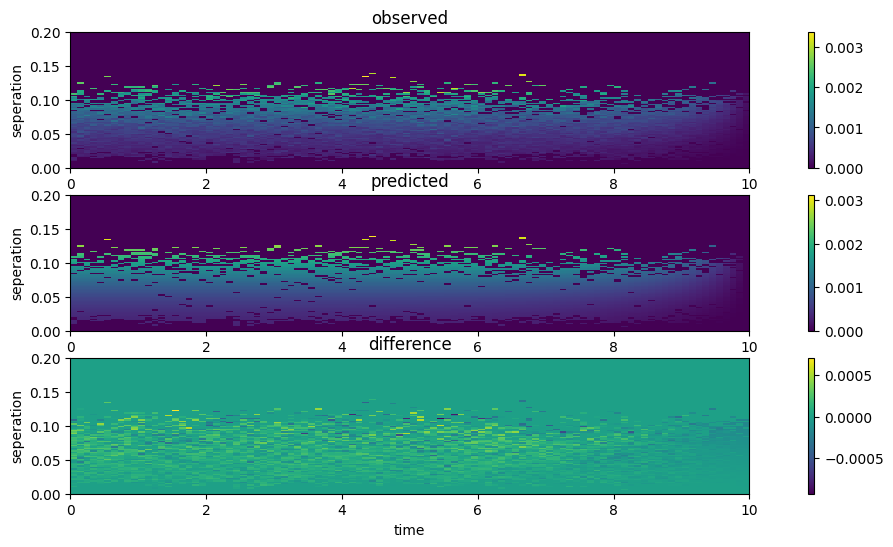

In [11]:
fig, ax = plt.subplots(3, 1) 
scale = ax[0].imshow(np.flip(sampled,axis=0), interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10)
scale2 = ax[1].imshow(np.flip(evaluated,axis=0), interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10)
scale3 = ax[2].imshow(np.flip((evaluated-sampled),axis=0), interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10)
fig.set_size_inches(15,6)
fig.colorbar(scale, ax=ax[0])
fig.colorbar(scale2, ax=ax[1])
fig.colorbar(scale3, ax=ax[2])

ax[0].set_xlabel('time')
ax[0].set_ylabel('seperation')
ax[0].set_title("observed")

ax[1].set_xlabel('time')
ax[1].set_ylabel('seperation')
ax[1].set_title("predicted")

ax[2].set_xlabel('time')
ax[2].set_ylabel('seperation')
ax[2].set_title("difference")

In [9]:
plt.plot(sampled[:,200])
plt.plot(evaluated[:,200])
plt.xlabel("seperation")
plt.ylabel("return")
plt.legend(labels=["observed","predicted"])

IndexError: index 200 is out of bounds for axis 1 with size 100

In [ ]:
# start of random play ground
assert(1==0)

In [ ]:
sampled[:200].shape

In [ ]:
np.array([1,2,3]) / np.array([1,2,3])

In [ ]:
sampled-evaluated

In [ ]:
sampled[314][0]

In [ ]:
evaluated[314][0]

In [ ]:
image.shape

In [ ]:
A = np.random.random((5,5))
A[2,2]=0.
plt.imshow(A, interpolation='nearest')

In [ ]:
A

In [ ]:
N

In [ ]:
dictionary[(1,312)]

In [ ]:
import sys
sys.getsizeof(dictionary)


In [ ]:
import csv

In [ ]:

with open(f'bins_{num_eps}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(dictionary.keys()))
    writer.writeheader()
    writer.writerow(dictionary)

In [ ]:
list(dictionary.keys())

In [ ]:
dictionary.keys()

In [ ]:
N = len(separations)
S_n = 0.0
returns = np.zeros(N)
discount = np.exp(-NU*delta_t)
for i in range(1,N+1):
    S_n = S_n*discount + penalty(separations[N-i],PHI,BETA,delta_t)
    returns[N-i] = S_n
    #S_n = np.append(S_n, S_n[i-1]*discount + penalty(separations[N-i],PHI,BETA,delta_t))

In [ ]:
len(returns)

In [ ]:
len(tspan)

In [ ]:
len(separations)

In [ ]:
plt.plot(np.arange(N) * delta_t,returns)

In [ ]:
np.arange(N) * delta_t

In [ ]:
N = len(separations)-1
S_n = np.array([(PHI**2+BETA)*np.exp(0)*separations[-1]**2*delta_t])
for r in reversed(separations[:-1]):
    S_n = S_n.append(S_n,(PHI**2+BETA)*np.exp(-nu*(N-index)*delta_t)*separations[index]**2*delta_t
    

In [ ]:
len(separations)

In [ ]:
len(tspan)

In [ ]:
tspan

In [ ]:
# Plot observed distribution don't plot early values before the distribution has settled into the stationary distribution
n,bins,_ = plt.hist(separations[1000:], bins=500, density=True, alpha=0.5)
x_points = np.arange(r_d,max(separations[1000:]),0.01)
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))
plt.yscale("log")
plt.ylim(bottom=10**(-7),top=10**(2))

## Now run within the environment to check that results are similiar 

In [ ]:
# run environment with same parameters as above this is a good bit slower than just the bare bone numerics
fixed_agent = FixedPhi(PHI)
env = synthetic_env(r_d, D=D,kappa=kappa)
env.deltaT= 0.005
env.limit = 10000
observed_distances = []
while not env.isOver():
    action = fixed_agent.sample_action(env.getState())
    reward = env.step(action)
    observed_distances.append(env.dist())

In [ ]:
n,bins,_ = plt.hist(observed_distances, bins=500, density=True, alpha=0.5)
x_points = np.arange(r_d,max(observed_distances[1000:]),0.01)
plt.plot(x_points,expected_prop_2d(x_points,PHI,D,r_d))
plt.yscale("log")
plt.ylim(bottom=10**(-7),top=10**(2))